This notebook investigates the student population given incoming attributes

# Preparing the data
We need to load pre survey (incoming attitudes), post survey (demographics data), and worksheet (incoming knowledge).

In [63]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [64]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import ranksums
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10, 6
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Grabbing the worksheet data

In [65]:
%reload_ext utils_read_parsing
#grab worksheet data - beers
worksheets = get_worksheet_metadata('beers')
pre_b = get_pre_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre_b = pre_b[pre_b['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre_b['sid'] = pre_b['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])

#grab worksheet data - caps
worksheets = get_worksheet_metadata('caps')
pre_c = get_pre_worksheet(sim='caps')

ids = get_students_to_analyze_log_worksheets('caps')
pre_c= pre_c[pre_c['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre_c['sid'] = pre_c['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])

pre_b.index = pre_b['sid']
pre_c.index = pre_c['sid']
pre_b.drop(['Student ID','sid'],axis=1,inplace=True)
pre_c.drop(['Student ID','sid'],axis=1,inplace=True)

## Grabbing survey data

In [66]:
pre_survey_df = pd.read_csv('pre_survey_results.txt', sep='\t')
pre_survey_df.index = pre_survey_df['sid']
pre_survey_df.drop(['Unnamed: 0','sid'],inplace=True,axis=1)
pre_survey_df.head()

,[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs],similar_L,similar_C,same_L,same_C,prior_number_virtual_labs,perceivedvalue.0,...,taskinterpretation.0,taskinterpretation.1,taskinterpretation.2,taskinterpretation.3,taskinterpretation.4,pocc.0,pocc.1,pocc.2,pocc.3,pocc.4
sid,,,,,,,,,,,,,,,,,,,,,
77047160,1.0,1.0,1.0,NaN,0,0,0,0,2,Mostly,...,Mostly,Somewhat,Mostly,Somewhat,Somewhat,Often,Often,Often,Sometimes,Often
23836160,1.0,1.0,NaN,NaN,0,0,0,0,0,Somewhat,...,Definitely,Definitely,Mostly,Definitely,Definitely,Often,Sometimes,Sometimes,Sometimes,Often
64006159,NaN,1.0,1.0,NaN,0,0,0,0,1,Not at all,...,Somewhat,Somewhat,Somewhat,Mostly,Somewhat,Often,Often,Often,Often,Sometimes
24566161,1.0,1.0,1.0,NaN,0,1,0,0,3,Somewhat,...,Mostly,Definitely,Mostly,Definitely,Mostly,Almost always,Almost always,Often,Often,Often
46792161,NaN,1.0,NaN,NaN,1,0,0,0,2,Somewhat,...,Definitely,Somewhat,Not at all,Mostly,Definitely,Often,Often,Often,Sometimes,Almost always


In [67]:
post_survey_df = pd.read_csv('post_survey_results.txt', sep='\t')
post_survey_df = post_survey_df[['age','english.0','english.1','gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman','major','year-1st year undergraduate','year-2nd year undergraduate','year-3rd year undergraduate','year-4th year undergraduate','sim','sim_index','sid']]
post_survey_df.index = post_survey_df['sid']
post_survey_df.fillna(0,inplace=True)
post_survey_df = post_survey_df[post_survey_df['sim_index']==2]
post_survey_df.drop(['sid'],axis=1,inplace=True)
post_survey_df.head()

,age,english.0,english.1,gender-Gender non conforming/non-binary,gender-Man,gender-Prefer not to answer,gender-Woman,major,year-1st year undergraduate,year-2nd year undergraduate,year-3rd year undergraduate,year-4th year undergraduate,sim,sim_index
sid,,,,,,,,,,,,,,
77047160,18-19,Fluent,Fluent,0.0,0.0,0.0,1.0,*Non science or applied science major,1.0,0.0,0.0,0.0,Capacitance,2
90447168,20-22,Average,Fluent,0.0,1.0,0.0,0.0,*Undeclared,1.0,0.0,0.0,0.0,Capacitance,2
24511163,20-22,Fluent,Fluent,0.0,1.0,0.0,0.0,Mechanical Engineering,1.0,0.0,0.0,0.0,Capacitance,2
27451164,18-19,Fluent,Fluent,0.0,0.0,0.0,1.0,Electrical Engineering,1.0,0.0,0.0,0.0,Capacitance,2
46792161,18-19,Fluent,Fluent,0.0,1.0,0.0,0.0,Mechanical Engineering,1.0,0.0,0.0,0.0,Capacitance,2


## Putting it together

In [68]:
data = pd.concat([pre_b,pre_c,post_survey_df,pre_survey_df],axis=1)
data.rename(columns={"sim": "second sim"},inplace=True)
data.drop('sim_index',axis=1,inplace=True)
data.reset_index(inplace=True)

In [69]:
data.sort_values('sid').head(12)

,sid,Concentration,Wavelength,Width,Area,Separation,Battery voltage,age,english.0,english.1,...,taskinterpretation.0,taskinterpretation.1,taskinterpretation.2,taskinterpretation.3,taskinterpretation.4,pocc.0,pocc.1,pocc.2,pocc.3,pocc.4
0,10127163,1.0,1.0,1.0,3,3,3,20-22,Fluent,Fluent,...,Definitely,Not at all,Not at all,Somewhat,Definitely,Almost always,Often,Often,Often,Almost always
1,10192168,1.0,1.0,1.0,1,1,1,18-19,Fluent,Fluent,...,Mostly,Definitely,Not at all,Definitely,Definitely,Often,Often,Often,Often,Often
2,10232160,1.0,1.0,1.0,1,1,1,18-19,Average,Average,...,Mostly,Mostly,Somewhat,Mostly,Somewhat,Almost always,Often,Often,Sometimes,Often
3,10375163,0.0,1.0,1.0,1,1,0,18-19,Fluent,Fluent,...,Mostly,Mostly,Somewhat,Definitely,Mostly,Sometimes,Almost never,Almost never,Sometimes,Almost never
4,10420167,1.0,1.0,0.0,2,2,3,18-19,Fluent,Fluent,...,Definitely,Somewhat,Not at all,Mostly,Mostly,Often,Almost always,Often,Sometimes,Often
5,10537160,1.0,1.0,0.0,0,0,0,18-19,Fluent,Fluent,...,Mostly,Not at all,Not at all,Somewhat,Somewhat,Sometimes,Sometimes,Often,Almost never,Almost never
6,10561164,2.0,1.0,2.0,1,2,3,20-22,Fluent,Fluent,...,Mostly,Mostly,Not at all,Mostly,Somewhat,Often,Almost never,Often,Almost never,Sometimes
7,10708152,2.0,1.0,2.0,1,1,1,18-19,Fluent,Fluent,...,Definitely,Somewhat,Not at all,Definitely,Mostly,Often,Almost always,Almost always,Sometimes,Almost always
8,10866146,3.0,1.0,1.0,1,2,1,17 and under,Fluent,Fluent,...,Mostly,Somewhat,Mostly,Somewhat,Somewhat,Sometimes,Often,Often,Sometimes,Sometimes
9,10908162,2.0,0.0,0.0,0,1,1,18-19,Average,Average,...,Mostly,Mostly,Mostly,Somewhat,Mostly,Almost always,Almost always,Often,Often,Almost always


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011BE4A90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000180292E8>]], dtype=object)

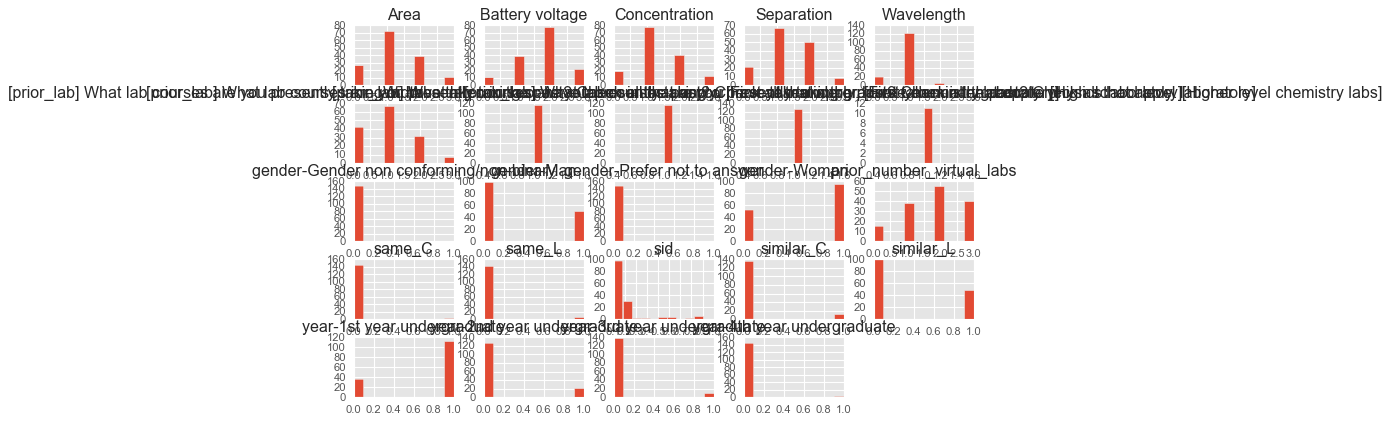

In [70]:
data.hist()

## Exporting the data

In [71]:
export_data = data.copy()
export_data.to_csv('dataframe_all_incoming_factors_by_student.csv')

## Convert lickert scale and other values from strings to integers

In [72]:
value_converter = {'age':{
    'Prefer not to answer':0,
    '20-22':21,
    '18-19':19,
    '17 and under':17,
    },
'english.0':{
    'Fluent':3,
    'Average':2,
    'Beginner':1,
    },
'english.1':{
    'Fluent':3,
    'Average':2,
    'Beginner':1,
    },
'second sim':{
    'Absorbance':2,
    'Capacitance':1
    },
'perceivedvalue.0':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'perceivedvalue.1':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'perceivedvalue.2':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'perceivedvalue.3':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'taskinterpretation.0':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'taskinterpretation.1':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'taskinterpretation.2':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'taskinterpretation.3':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'taskinterpretation.4':{
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    }, 
'pocc.0':{
    'Almost always':4,
    'Sometimes':2,
    'Almost never':1,
    'Often':3,
    },
'pocc.1':{
    'Almost always':4,
    'Sometimes':2,
    'Almost never':1,
    'Often':3,
    },
'pocc.2':{
    'Almost always':4,
    'Sometimes':2,
    'Almost never':1,
    'Often':3,
    },
'pocc.3':{
    'Almost always':4,
    'Sometimes':2,
    'Almost never':1,
    'Often':3,
    },
'pocc.4':{
    'Almost always':4,
    'Sometimes':2,
    'Almost never':1,
    'Often':3,
    }
}


In [82]:
for column in value_converter.keys():
    for value,replacement in value_converter[column].iteritems():
        data[column] = data[column].replace(value,replacement)
data.fillna(0,inplace=True)

In [83]:
for c in data.columns:
    if data[c].dtype not in ['int64','float64']:
        print c, data[c].dtype

In [85]:
data.drop('major',axis=1,inplace=True)

In [110]:
demo_columns = ['age','english.0','english.1','gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman','year-1st year undergraduate','year-2nd year undergraduate','year-3rd year undergraduate','year-4th year undergraduate','second sim','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs]','similar_L','similar_C','same_L','same_C','prior_number_virtual_labs']
att_columns = ['perceivedvalue.0','perceivedvalue.1','perceivedvalue.2','perceivedvalue.3','taskinterpretation.0','taskinterpretation.1','taskinterpretation.2','taskinterpretation.3','taskinterpretation.4','pocc.0','pocc.1','pocc.2','pocc.3','pocc.4']
knowledge_columns = ['Concentration','Wavelength','Width','Area','Separation','Battery voltage']

# Who are our students?

In [86]:
N = len(set(data['sid']))
print "The study includes {0} students.".format(N)

The study includes 148 students.


## What is their background?

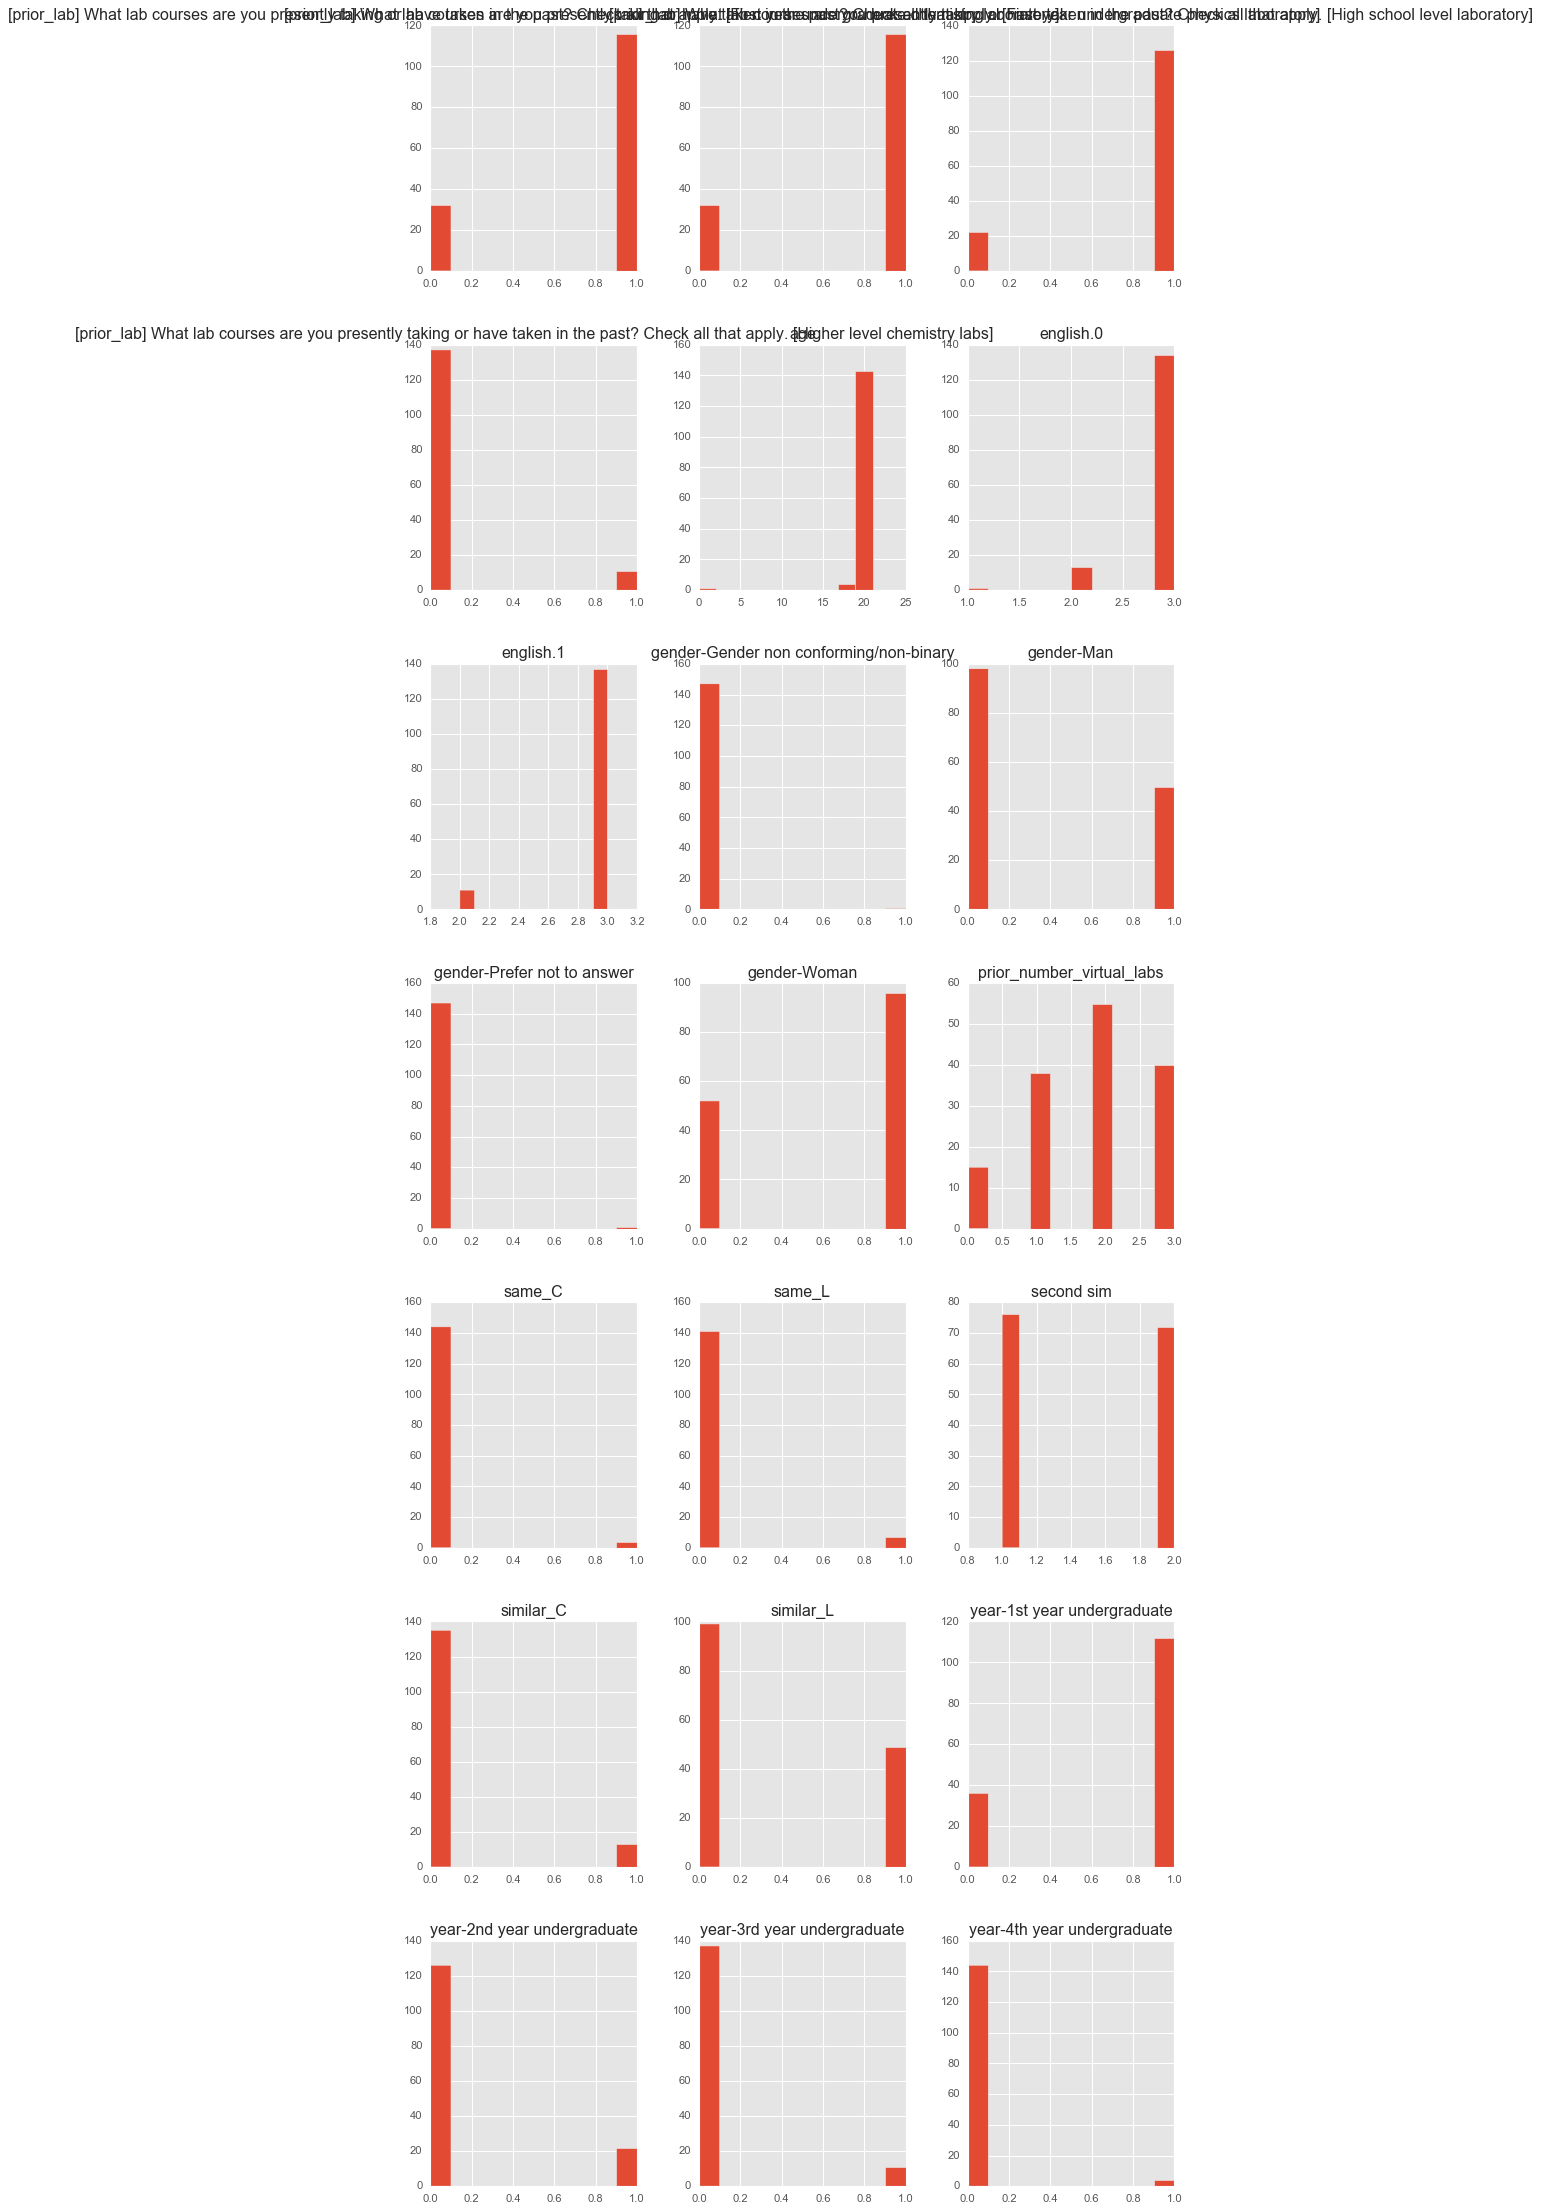

In [125]:
data[demo_columns].hist(figsize=(12,40),layout=(len(demo_columns)/3+1,3));

## What are their incoming attitudes?

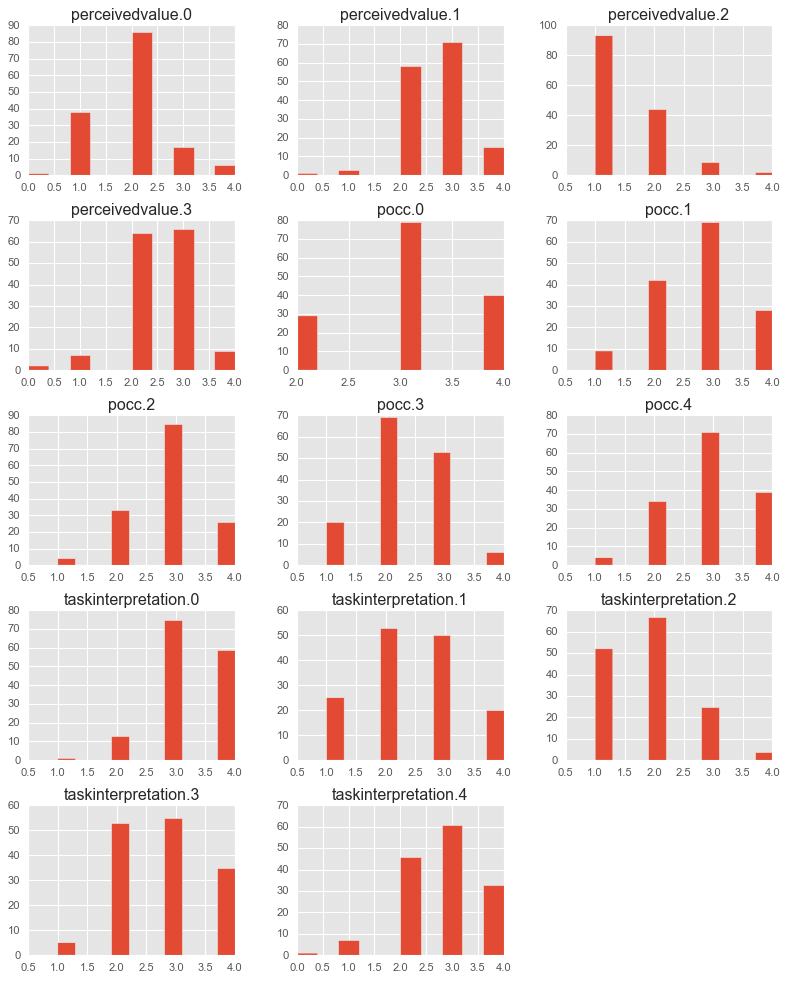

In [127]:
data[att_columns].hist(figsize=(12,15),layout=(len(att_columns)/3+1,3));

In [133]:
pca = decomposition.PCA(n_components=10)
pca.fit(data[att_columns])
pca.explained_variance_ratio_.cumsum()

array([ 0.23 ,  0.366,  0.463,  0.555,  0.639,  0.702,  0.753,  0.802,
        0.846,  0.888])

The first three components of the PCA exaplined almost 50% of the data.

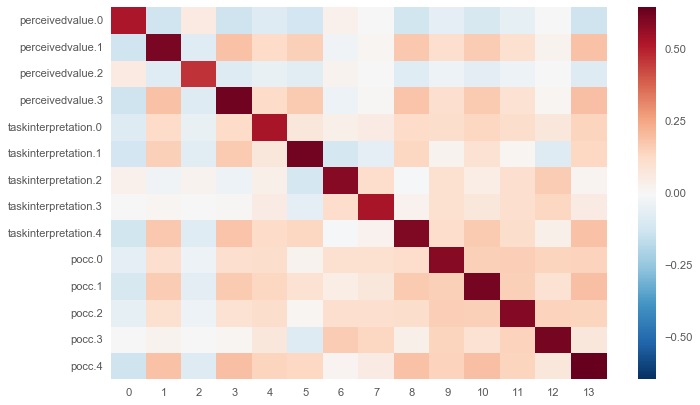

In [156]:
NC = 2
pca = decomposition.PCA(n_components=NC)
pca.fit(data[att_columns])
X = pca.transform(data[att_columns])

sns.heatmap(pca.get_covariance(),yticklabels=att_columns)

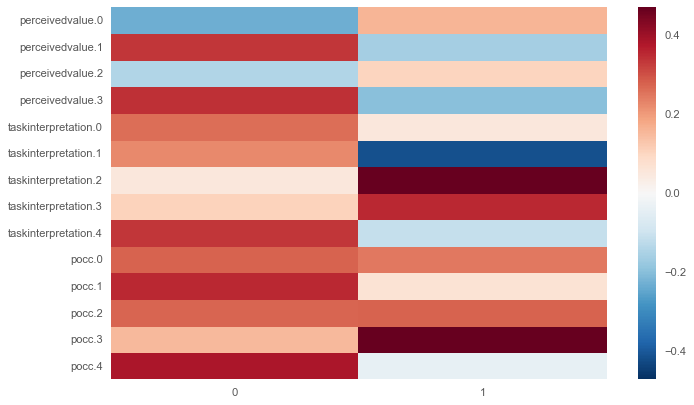

In [157]:
sns.heatmap(pca.components_.T,yticklabels=att_columns)